# [E-06] 영화리뷰 텍스트 감성분석하기

* 루브릭 평가 기준
    * 3가지 이상의 모델이 성공적으로 시도됨
    * gensim의 유사 단어 찾기를 활용해 자체 학습한 임베딩과 사전학습 임베딩을 적절히 분석함.
    * 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함.

### 데이터 준비와 확인

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [2]:
# train data 몇 개인지 확인
print(len(train_data))

150000


In [3]:
# train data 출력
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
# test data 몇 개인지 확인
print(len(test_data))

50000


In [5]:
# test data 출력
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터로더 구성

In [6]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print('훈련 샘플 개수: {}, 테스트 샘플 개수: {}'.format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 샘플 개수: 49157


### 모델 구성을 위한 데이터 분석 및 가공

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from collections import Counter

In [11]:
# decoding
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [12]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
total_data_text = list(X_train) + list(X_test)

In [13]:
# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [14]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
plt.clf()

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


<Figure size 432x288 with 0 Axes>

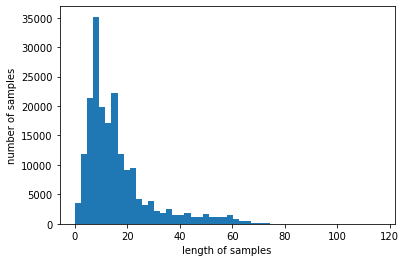

In [15]:
plt.hist([len(s) for s in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 가정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [18]:
# padding
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [19]:
# validation set 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]


partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


### RNN 모델로 훈련해보기

In [20]:
from tensorflow import keras

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 설계
rnn = keras.Sequential()
rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용
rnn.add(keras.layers.GRU(128))  # LSTM 모델을 발전 시킨 모델이라고 한다.
rnn.add(keras.layers.Dense(8, activation='relu'))
rnn.add(keras.layers.Dense(1, activation='sigmoid')) 

rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               126720    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,127,761
Trainable params: 2,127,761
Non-trainable params: 0
_________________________________________________________________


In [21]:
rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 6s 14ms/step - loss: 0.4160 - accuracy: 0.8091 - val_loss: 0.3517 - val_accuracy: 0.8444
Epoch 2/10
208/208 [==============================] - 3s 12ms/step - loss: 0.3152 - accuracy: 0.8646 - val_loss: 0.3315 - val_accuracy: 0.8563
Epoch 3/10
208/208 [==============================] - 3s 12ms/step - loss: 0.2751 - accuracy: 0.8836 - val_loss: 0.3290 - val_accuracy: 0.8589
Epoch 4/10
208/208 [==============================] - 3s 12ms/step - loss: 0.2433 - accuracy: 0.8996 - val_loss: 0.3417 - val_accuracy: 0.8584
Epoch 5/10
208/208 [==============================] - 3s 12ms/step - loss: 0.2176 - accuracy: 0.9112 - val_loss: 0.3573 - val_accuracy: 0.8556
Epoch 6/10
208/208 [==============================] - 3s 12ms/step - loss: 0.1959 - accuracy: 0.9215 - val_loss: 0.3922 - val_accuracy: 0.8540
Epoch 7/10
208/208 [==============================] - 3s 12ms/step - loss: 0.1766 - accuracy: 0.9298 - val_loss: 0.4091 - val_accuracy: 0.8477

In [22]:
results_rnn = rnn.evaluate(x_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.5361 - accuracy: 0.8390
[0.5361088514328003, 0.83904629945755]


In [23]:
history_dict_rnn = history.history
print(history_dict_rnn.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


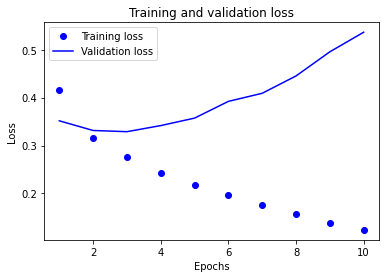

In [24]:
import matplotlib.pyplot as plt

acc = history_dict_rnn['accuracy']
val_acc = history_dict_rnn['val_accuracy']
loss = history_dict_rnn['loss']
val_loss = history_dict_rnn['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

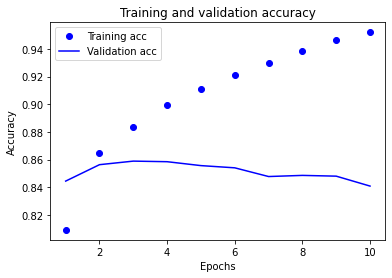

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN 모델

In [26]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 

cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn.add(keras.layers.Conv1D(32, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(32, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          44832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [27]:
# 학습 환경 설정
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
415/415 [==============================] - 5s 7ms/step - loss: 0.4092 - accuracy: 0.8069 - val_loss: 0.3327 - val_accuracy: 0.8546
Epoch 2/10
415/415 [==============================] - 2s 6ms/step - loss: 0.2743 - accuracy: 0.8869 - val_loss: 0.3240 - val_accuracy: 0.8607
Epoch 3/10
415/415 [==============================] - 3s 6ms/step - loss: 0.1805 - accuracy: 0.9317 - val_loss: 0.3710 - val_accuracy: 0.8512
Epoch 4/10
415/415 [==============================] - 2s 6ms/step - loss: 0.0984 - accuracy: 0.9659 - val_loss: 0.4801 - val_accuracy: 0.8469
Epoch 5/10
415/415 [==============================] - 2s 6ms/step - loss: 0.0579 - accuracy: 0.9800 - val_loss: 0.5776 - val_accuracy: 0.8421
Epoch 6/10
415/415 [==============================] - 2s 6ms/step - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.7050 - val_accuracy: 0.8434
Epoch 7/10
415/415 [==============================] - 3s 6ms/step - loss: 0.0316 - accuracy: 0.9893 - val_loss: 0.7633 - val_accuracy: 0.8373
Epoch 

In [28]:
results_cnn = cnn.evaluate(x_test,  y_test, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 0.9001 - accuracy: 0.8350
[0.9001158475875854, 0.8350387811660767]


In [29]:
history_dict_cnn = history.history
print(history_dict_cnn.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


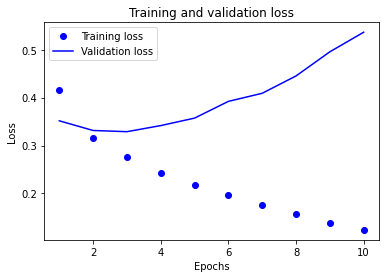

In [30]:
import matplotlib.pyplot as plt

acc = history_dict_cnn['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

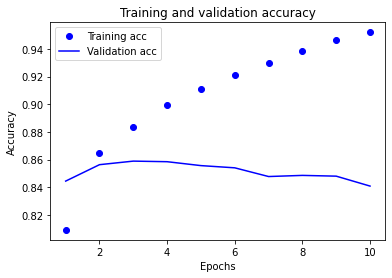

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D 레이어 하나만으로 학습해보기

In [32]:
gmp = keras.Sequential()
gmp.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp.add(keras.layers.GlobalMaxPooling1D())
gmp.add(keras.layers.Dense(8, activation='relu'))
gmp.add(keras.layers.Dense(1, activation='sigmoid'))

gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [33]:
gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 2s 6ms/step - loss: 0.4790 - accuracy: 0.8011 - val_loss: 0.3532 - val_accuracy: 0.8454
Epoch 2/10
208/208 [==============================] - 1s 5ms/step - loss: 0.3175 - accuracy: 0.8652 - val_loss: 0.3370 - val_accuracy: 0.8532
Epoch 3/10
208/208 [==============================] - 1s 5ms/step - loss: 0.2686 - accuracy: 0.8901 - val_loss: 0.3424 - val_accuracy: 0.8541
Epoch 4/10
208/208 [==============================] - 1s 5ms/step - loss: 0.2277 - accuracy: 0.9109 - val_loss: 0.3554 - val_accuracy: 0.8536
Epoch 5/10
208/208 [==============================] - 1s 5ms/step - loss: 0.1878 - accuracy: 0.9308 - val_loss: 0.3779 - val_accuracy: 0.8510
Epoch 6/10
208/208 [==============================] - 1s 5ms/step - loss: 0.1480 - accuracy: 0.9490 - val_loss: 0.4083 - val_accuracy: 0.8476
Epoch 7/10
208/208 [==============================] - 1s 5ms/step - loss: 0.1113 - accuracy: 0.9651 - val_loss: 0.4432 - val_accuracy: 0.8461
Epoch 

In [34]:
results_gmp = gmp.evaluate(x_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.5640 - accuracy: 0.8363
[0.564029335975647, 0.8362593054771423]


In [35]:
history_dict_gmp = history.history
print(history_dict_gmp.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


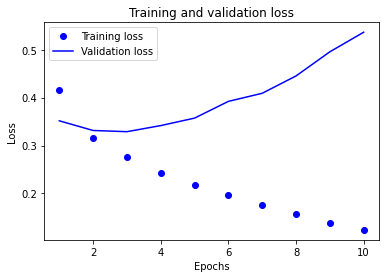

In [36]:
import matplotlib.pyplot as plt

acc = history_dict_gmp['accuracy']
val_acc = history_dict_gmp['val_accuracy']
loss = history_dict_gmp['loss']
val_loss = history_dict_gmp['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

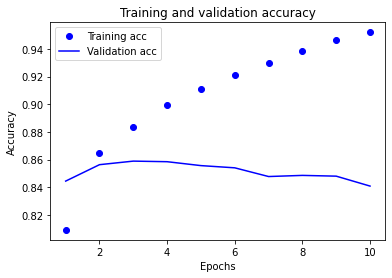

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
embedding_layer = rnn.layers[0]            # GRU로 학습된 모델을 대상으로 분석 
weights = embedding_layer.get_weights()[0]
print(weights.shape)   # shape: (vocab_size, embedding_dim)

(10000, 200)


In [40]:
import os
from gensim import models     # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-6, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn.get_weights()[0]
for i in range(6, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.05943523, -0.04314158, -0.02425041,  0.02351749,  0.03543142,
       -0.04040504,  0.04045698,  0.01012678,  0.07263764,  0.00767093,
        0.01756792, -0.02787288,  0.02298858,  0.00055573,  0.04499599,
       -0.00882702, -0.01008219, -0.00941781, -0.04884919,  0.05322327,
       -0.044742  , -0.02811575,  0.02820921, -0.05431595, -0.04509468,
       -0.02582193, -0.01692758, -0.01664509, -0.02867678, -0.03068061,
       -0.01377297,  0.04367522, -0.08715362,  0.0188116 , -0.00971557,
       -0.06596037, -0.01676772,  0.00263284, -0.04279811, -0.00262269,
       -0.05783612,  0.02956448, -0.03712275, -0.01993093, -0.09330436,
       -0.02202157, -0.00554809,  0.04187082, -0.05909657,  0.02596716,
        0.03260135,  0.06007127,  0.0607147 ,  0.05235593,  0.06153915,
        0.02661307,  0.01354994, -0.00665766, -0.01245556, -0.06967123,
       -0.01089633,  0.05267742, -0.03557567, -0.01230204, -0.03608905,
        0.00245772, -0.08149143, -0.04575545, -0.01892043, -0.01

In [43]:
word_vectors.similar_by_word("어벤져스")

[('99', 0.7902316451072693),
 ('ㅉㅉ', 0.76581209897995),
 ('방식', 0.7618013024330139),
 ('띄워', 0.7585567831993103),
 ('고독', 0.7580589652061462),
 ('시리즈', 0.7560260891914368),
 ('명절', 0.7526372075080872),
 ('범', 0.7511965036392212),
 ('라마', 0.744321346282959),
 ('노아', 0.7442929744720459)]

### 회고

* 우선 이번 노드는 자연어 처리 분야에 어려움을 느끼는 나에게 있어 난이도 최강이었다. cv가 쉽다는 건 아니지만 그냥 nlp는 너무 어렵다...그래서 과감하게 루브릭 평가 기준 세번째는 포기했다. 
* 일단 어려운 부분 첫번째, 특수문자 처리, 패딩 등 자연어 데이터를 다듬는 과정에 대한 이해는 되지만 코드를 작성해보라고 한다면 시도조차 못할 것 같다.
* 두번째, cv나 회귀모델에서도 그래프 사용이 익숙하지 않은데 이를 nlp로 그래프를 그리려니 힘들다: 이는 그래프 관련 메서드가 아직 어려워서 그런 것이니 그래프 관련 코드 부분을 좀 더 공부해야할 것 같다.

* 참고
    * https://ceuity.tistory.com/11
    * https://velog.io/@shoulmon/SSACAIFFEL-20210114-%EB%84%A4%EC%9D%B4%EB%B2%84-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0-jvwzuadq
    * https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=7f4b5ad379d6c6a0abafc804958a8754559eb939&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f73746572656f2d77656c642f6578706c6f726174696f6e732f376634623561643337396436633661306162616663383034393538613837353435353965623933392f45345f50726f6a6563745f4e617665725f4d6f7669655f53656e74696d656e745f436c617373696669636174696f6e5f76322e6970796e62&logged_in=false&nwo=stereo-weld%2Fexplorations&path=E4_Project_Naver_Movie_Sentiment_Classification_v2.ipynb&platform=android&repository_id=328663132&repository_type=Repository&version=96